# Insert Title Here

## Imports

In [1]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk import ngrams

from collections import Counter
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Data Collection

In [3]:
df_fakenews1 = pd.read_csv('data/fake news dataset.csv')
df_fakenews1.rename(columns={'article': 'Content'}, inplace=True) #renamed column


df_fakenews2 = pd.read_csv('data/fake_or_real_news.csv')
df_fakenews2.rename(columns={'text': 'Content'}, inplace=True) #renamed column

#combining two dataset into a single DataFrame
df_FakeNews = pd.concat([df_fakenews1, df_fakenews2], ignore_index=True)

#assigning new values (raplacing the existing values 'REAL' and 'FAKE' with 0 and 1, respectively in the 'label' column)
df_FakeNews.loc[:, 'label'] = df_FakeNews['label'].replace({'REAL': 0, 'FAKE': 1})
df_FakeNews

,label,Content,Unnamed: 0,title
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",NaN,NaN
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...,NaN,NaN
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",NaN,NaN
3,0,"Kasama sa programa ang pananalangin, bulaklak ...",NaN,NaN
4,0,Linisin ang Friendship Department dahil dadala...,NaN,NaN
...,...,...,...,...
9536,0,The State Department told the Republican Natio...,4490.0,State Department says it can't find emails fro...
9537,1,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,8062.0,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...
9538,1,Anti-Trump Protesters Are Tools of the Oligar...,8622.0,Anti-Trump Protesters Are Tools of the Oligarc...
9539,0,"ADDIS ABABA, Ethiopia —President Obama convene...",4021.0,"In Ethiopia, Obama seeks progress on peace, se..."


In [4]:
#Loading news sites datasets and storing into DataFrames
df_rappler = pd.read_csv('data/rap_dataframe.csv')
df_rappler

,Link,Author,Content
0,https://www.rappler.com/life-and-style/literat...,[],"MANILA, Philippines – Finally! Best-selling Ja..."
1,https://www.rappler.com/nation/new-findings-ki...,['JAIRO BOLLEDO'],"MANILA, Philippines – The results of the lates..."
2,https://www.rappler.com/sports/football/tom-br...,[],Tom Brady was the ultimate winner on the field...
3,https://www.rappler.com/life-and-style/health-...,[],It’s one thing to know what makes people happy...
4,https://www.rappler.com/entertainment/music/ju...,[],Justin Bieber is the latest artist in a growin...
...,...,...,...
1197,https://www.rappler.com/entertainment/pageants...,[],"MANILA, Philippines – Thai businesswoman and C..."
1198,https://www.rappler.com/world/asia-pacific/chi...,[],"BEIJING, China – Luggage-laden passengers floc..."
1199,https://www.rappler.com/sports/nba/game-result...,[],Kawhi Leonard and Terance Mann each eclipsed 3...
1200,https://www.rappler.com/sports/nba/game-result...,[],Nikola Vucevic continued his recent dominance ...


In [5]:
df_gma1 = pd.read_csv('data/gma-10000.csv')

df_gma2 = pd.read_csv('data/gma_dataframe.csv')

df_GMA = pd.concat([df_gma1,df_gma2], ignore_index=True)
df_GMA

,Unnamed: 0,Link,Author,Content
0,0.0,https://www.gmanetwork.com/news/balitambayan/p...,[],Arestado ng Laguna Police ang isang elementary...
1,1.0,https://www.gmanetwork.com/news/topstories/reg...,['By GMA Integrated News'],A barangay kagawad was shot dead in front of b...
2,2.0,https://www.gmanetwork.com/news/topstories/wor...,[],"GENEVA, Switzerland - Taliban restrictions on ..."
3,3.0,https://www.gmanetwork.com/news/topstories/nat...,['By GMA Integrated News'],The National Privacy Commission (NPC) has issu...
4,4.0,https://www.gmanetwork.com/news/topstories/wor...,[],"STOCKHOLM, Sweden - More than 600 young people..."
...,...,...,...,...
16001,NaN,https://www.gmanetwork.com/news/topstories/wor...,"['By SOO-HYANG CHOI, Reuters']",SEOUL - North Korea said on Sunday it had test...
16002,NaN,https://www.gmanetwork.com/news/topstories/wor...,[],Former US President Jimmy Carter has decided t...
16003,NaN,https://www.gmanetwork.com/news/topstories/reg...,['By GMA Integrated News'],The search for the Cessna plane which went mis...
16004,NaN,https://www.gmanetwork.com/news/topstories/reg...,['By GMA Integrated News'],The search and rescue operations for the missi...


In [6]:
# Drop duplicates
df_FakeNews = df_FakeNews.drop_duplicates()
df_rappler = df_rappler.drop_duplicates()
df_GMA = df_GMA.drop_duplicates()

In [7]:
display("df_FakeNews",df_FakeNews.head(),
        "df_rappler", df_rappler.head(), 
        "df_GMA", df_GMA.head())

'df_FakeNews'

,label,Content,Unnamed: 0,title
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",NaN,NaN
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...,NaN,NaN
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",NaN,NaN
3,0,"Kasama sa programa ang pananalangin, bulaklak ...",NaN,NaN
4,0,Linisin ang Friendship Department dahil dadala...,NaN,NaN


'df_rappler'

,Link,Author,Content
0,https://www.rappler.com/life-and-style/literat...,[],"MANILA, Philippines – Finally! Best-selling Ja..."
1,https://www.rappler.com/nation/new-findings-ki...,['JAIRO BOLLEDO'],"MANILA, Philippines – The results of the lates..."
2,https://www.rappler.com/sports/football/tom-br...,[],Tom Brady was the ultimate winner on the field...
3,https://www.rappler.com/life-and-style/health-...,[],It’s one thing to know what makes people happy...
4,https://www.rappler.com/entertainment/music/ju...,[],Justin Bieber is the latest artist in a growin...


'df_GMA'

,Unnamed: 0,Link,Author,Content
0,0.0,https://www.gmanetwork.com/news/balitambayan/p...,[],Arestado ng Laguna Police ang isang elementary...
1,1.0,https://www.gmanetwork.com/news/topstories/reg...,['By GMA Integrated News'],A barangay kagawad was shot dead in front of b...
2,2.0,https://www.gmanetwork.com/news/topstories/wor...,[],"GENEVA, Switzerland - Taliban restrictions on ..."
3,3.0,https://www.gmanetwork.com/news/topstories/nat...,['By GMA Integrated News'],The National Privacy Commission (NPC) has issu...
4,4.0,https://www.gmanetwork.com/news/topstories/wor...,[],"STOCKHOLM, Sweden - More than 600 young people..."


In [8]:
df_news = pd.concat([df_FakeNews,df_rappler, df_GMA], ignore_index=True)
df_news['label'] = pd.to_numeric(df_news['label'], errors='coerce').fillna(0.0)

# Drop duplicates
df_news = df_news.drop_duplicates()
df_news

,label,Content,Unnamed: 0,title,Link,Author
0,0.0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,...",NaN,NaN,NaN,NaN
1,0.0,Kilala rin ang singer sa pagkumpas ng kanyang ...,NaN,NaN,NaN,NaN
2,0.0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma...",NaN,NaN,NaN,NaN
3,0.0,"Kasama sa programa ang pananalangin, bulaklak ...",NaN,NaN,NaN,NaN
4,0.0,Linisin ang Friendship Department dahil dadala...,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
24035,0.0,The winner of the special election in Cavite t...,NaN,NaN,https://www.gmanetwork.com/news/topstories/reg...,"['By RICHA NORIEGA, GMA Integrated News']"
24036,0.0,The remains of four people inside the Cessna p...,NaN,NaN,https://www.gmanetwork.com/news/topstories/reg...,"['By RICHA NORIEGA, GMA Integrated News']"
24037,0.0,A Kabataan Party-list representative visited t...,NaN,NaN,https://www.gmanetwork.com/news/topstories/nat...,[]
24038,0.0,The Philippine Coast Guard is expected to have...,NaN,NaN,https://www.gmanetwork.com/news/topstories/nat...,"['By RICHA NORIEGA, GMA Integrated News']"


In [9]:
df_news['label'] = df_news['label'].astype(int)
df_news.drop(["Unnamed: 0", "Link", "Author", "title"], axis=1, inplace=True)
df_news

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
24035,0,The winner of the special election in Cavite t...
24036,0,The remains of four people inside the Cessna p...
24037,0,A Kabataan Party-list representative visited t...
24038,0,The Philippine Coast Guard is expected to have...


In [10]:
# Preprocessing function to remove '\n' and '\t'
def remove_newline_tab(text):
    if isinstance(text, str):
        return text.replace(r'\n', ' ').replace(r'\t', ' ')
    else:
        return text

# Apply preprocessing to 'Content' column in df_news
df_news['Content'] = df_news['Content'].apply(remove_newline_tab)
df_news

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
24035,0,The winner of the special election in Cavite t...
24036,0,The remains of four people inside the Cessna p...
24037,0,A Kabataan Party-list representative visited t...
24038,0,The Philippine Coast Guard is expected to have...


In [11]:
# Preprocessing function to remove links from text
def remove_links(text):
    # Regular expression pattern to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    
    # Replace URLs with an empty string
    return re.sub(url_pattern, '', text)

    # Apply preprocessing to 'Content' column in df_news
df_news['Content'] = df_news['Content'].astype(str).apply(remove_links)
df_news

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
24035,0,The winner of the special election in Cavite t...
24036,0,The remains of four people inside the Cessna p...
24037,0,A Kabataan Party-list representative visited t...
24038,0,The Philippine Coast Guard is expected to have...


In [12]:
def remove_images(text):
    # Define a regular expression pattern to match base64-encoded strings (images)
    base64_pattern = r"data:image\/(png|jpg|jpeg|gif|bmp);base64,[A-Za-z0-9+/=]+"

    # Use the re.sub() function to replace the base64-encoded strings with an empty string
    cleaned_text = re.sub(base64_pattern, '', text)

    return cleaned_text

df_news['Content'] = df_news['Content'].astype(str).apply(remove_images)
df_news

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
24035,0,The winner of the special election in Cavite t...
24036,0,The remains of four people inside the Cessna p...
24037,0,A Kabataan Party-list representative visited t...
24038,0,The Philippine Coast Guard is expected to have...


In [13]:
#Saving of Cleaned Data to CSV file
df_news.to_csv('cleaned_data.csv', index=False)

## Exploratory Data Analysis (EDA)

In [14]:
df_cleaneddata = pd.read_csv('cleaned_data.csv')
df_cleaneddata

,label,Content
0,0,"Ayon sa TheWrap.com, naghain ng kaso si Krupa,..."
1,0,Kilala rin ang singer sa pagkumpas ng kanyang ...
2,0,"BLANTYRE, Malawi (AP) -- Bumiyahe patungong Ma..."
3,0,"Kasama sa programa ang pananalangin, bulaklak ..."
4,0,Linisin ang Friendship Department dahil dadala...
...,...,...
24035,0,The winner of the special election in Cavite t...
24036,0,The remains of four people inside the Cessna p...
24037,0,A Kabataan Party-list representative visited t...
24038,0,The Philippine Coast Guard is expected to have...


In [15]:
df_cleaneddata.describe()

,label
count,24040.000000
mean,0.194384
std,0.395734
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [16]:
df_cleaneddata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24040 entries, 0 to 24039
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    24040 non-null  int64 
 1   Content  24039 non-null  object
dtypes: int64(1), object(1)
memory usage: 375.8+ KB


In [17]:
y = df_cleaneddata.label
print(f'Ratio of real and fake news:')
y.value_counts(normalize=True).rename({1: 'real', 0: 'fake'})

Ratio of real and fake news:


fake    0.805616
real    0.194384
Name: label, dtype: float64

NameError: name 'plt' is not defined

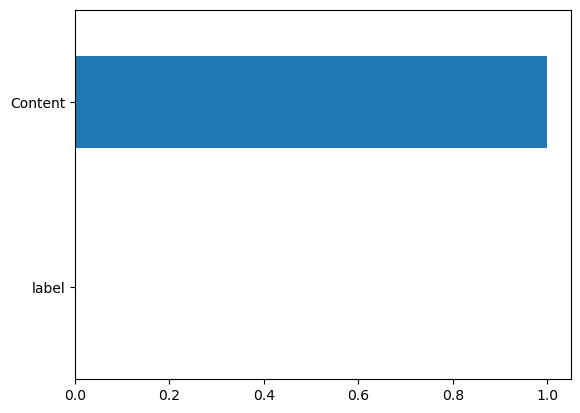

In [18]:
df_cleaneddata.isnull().sum().plot(kind="barh")
plt.show()

In [ ]:
df_cleaneddata.isnull().sum()

In [ ]:
df_cleaneddata.nunique()

In [ ]:
bins = np.linspace(0, 200, 40)

plt.figure(figsize=(12, 6))
plt.hist(df_cleaneddata[df_cleaneddata["label"] == 1]["Content"].str.len(), bins, alpha=0.5, label="Fake", color="#FF5733")
plt.hist(df_cleaneddata[df_cleaneddata["label"] == 0]["Content"].str.len(), bins, alpha=0.5, label="Real", color="#33FFB8")

plt.title('Distribution of Text Length for Fake/Real News')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
class_names = ['fake', 'real'] 
label_count = df_cleaneddata.label.value_counts()
plt.figure(figsize=(8, 6))
sns.barplot(x=label_count.index, y=label_count)
plt.title('Distribution of Fake/Real News',fontsize =14)

In [ ]:
y.head()

In [ ]:
titles = ' '.join(title for title in df_cleaneddata['Content'])
wordcloud = WordCloud(
    background_color='white', 
    max_words=300,
    width=800, 
    height=400,
).generate(titles)

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'\w+')
df_cleaneddata['Content'] = df_cleaneddata['Content'].apply(lambda x: tokenizer.tokenize(x))
print(df_cleaneddata.head())

In [ ]:
lemmatizer = WordNetLemmatizer()
df_cleaneddata['Content'] = df_cleaneddata['Content'].apply(lambda x: [lemmatizer.lemmatize(y) for y in x])
print(df_cleaneddata.head())

In [ ]:
df_cleaneddata['Content'] = df_cleaneddata['Content'].apply(lambda x: ' '.join(x))

In [ ]:
all_words = ' '.join([text for text in df_cleaneddata['Content']])
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [ ]:
def to_vector_Tfidf(df, col):
    from sklearn.feature_extraction.text import TfidfVectorizer
    vectorizer = TfidfVectorizer(max_features=2000)
    vectorizer.fit(df[col])
    return vectorizer.transform(df_cleaneddata[col])

In [ ]:
text_vector_tfidf = to_vector_Tfidf(df_cleaneddata, 'Content')
print("Shape of the tfidf vector: ", text_vector_tfidf.shape)
print(text_vector_tfidf.shape)

In [ ]:
df_cleaneddata = df_cleaneddata[['Content']].copy(deep=True)
df_cleaneddata

In [ ]:
df_cleaneddata['length'] = df_cleaneddata['Content'].str.count(' ') + 1
df_cleaneddata['LoR'] = df_cleaneddata['Content'].str.len()
df_cleaneddata

In [ ]:
df_cleaneddata["length"].mean()

In [ ]:
df_cleaneddata["LoR"].mean()

## Feature Engineering

## Modeling

## Conclusion

## References